In [1]:
from multiprocessing import Pool
import os
os.environ['OMP_NUM_THREADS'] = "1"

import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib 

from astropy.io import fits
from astropy.table import Table, join
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import spearmanr

from dustmaps.edenhofer2023 import Edenhofer2023Query

import pickle 
import sys
import tqdm

import emcee
import corner

import h5py

In [2]:
sys.path.append('../nanoKT_v1/')

In [3]:
import globalvars
dust_data = globalvars.DustData()

In [4]:
lambda0 = 15272.42
sigma0 = 1.15

from specfns import get_wavs, dopplershift
wavs = get_wavs()
window = (wavs > lambda0 - 10 )& (wavs < lambda0 + 10)

from filehandling import get_ca_res
from residual_process import reprocess

In [5]:
map_fname = '/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/edenhofer_out.h5'

with h5py.File(map_fname, 'r') as f:
    edenhofer = np.array(f['data'])
    dust_data.intake_map(edenhofer)

In [6]:
CA_meta = Table(fits.open('../Data/230420_CAResiduals/CA_meta.fits')[1].data)
CAresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230420_CAResiduals/'
CAMADGICSresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230829_MADGICSResiduals/'
starhorsepath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/env/APOGEE_STARHORSE/APOGEE_DR17_EDR3_STARHORSE_v2.fits'
starhorse = Table.read(starhorsepath, hdu = 1)
starhorse = starhorse['APOGEE_ID', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']

CA_meta = join(CA_meta, starhorse, keys = 'APOGEE_ID', join_type = 'left')

CA_meta_full = CA_meta.copy()

with open('/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/goodbad.pickle', mode = 'rb') as f:
    goodbad = pickle.load(f)

# added 02.01
# data_criteria = (((CA_meta['SNR'] > 80) & (CA_meta['TEFF'] > 5000)) | (CA_meta['SNR'] > 150)) & (CA_meta['ASPCAP_CHI2_1'] > 1) & (CA_meta['ASPCAP_CHI2_1'] < 5)
# print(np.sum(data_criteria))
# CA_meta= CA_meta[data_criteria]

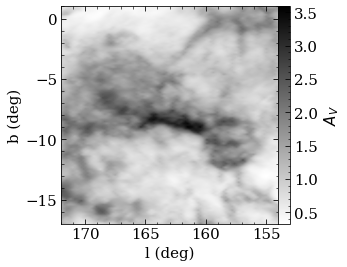

In [7]:
fig, ax = plt.subplots()
im = ax.imshow(np.nansum(dust_data.dustmap, axis = 2), origin = 'lower', cmap = 'binary', extent = (dust_data.l0-9, dust_data.l0+9, dust_data.b0-9, dust_data.b0+9))
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')


cax0 = ax.inset_axes([dust_data.l0-10,dust_data.b0-9 , 1, 18], transform =ax.transData)

fig.colorbar(im, ax = ax, cax = cax0, label = '$A_V$')
xmin, xmax = ax.get_xlim()
# ax.legend(loc = 'upper left')
ax.set_xlim(xmax, xmin)

plt.show()

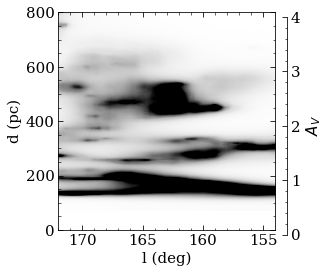

In [8]:
fig, ax = plt.subplots()
im = ax.imshow(np.nansum(dust_data.dustmap, axis = 1).T, origin = 'lower', cmap = 'binary', vmin = 0, vmax = 4, aspect = 18/800, extent = (dust_data.l0-9, dust_data.l0+9, 0, 800))
ax.set_xlabel('l (deg)')
ax.set_ylabel('d (pc)')
# ax.set_ylim(400,600)



cax0 = ax.inset_axes([dust_data.l0-10,dust_data.b0-9 , 0, 800], transform =ax.transData)

fig.colorbar(im, ax = ax, cax = cax0, label = '$A_V$')
xmin, xmax = ax.get_xlim()
# ax.legend(loc = 'upper left')
ax.set_xlim(xmax, xmin)

plt.show()

In [9]:
front = CA_meta['DIST'] < 400

signals_fg = np.zeros((np.sum(front), np.sum(window), 2))

for i in range(np.sum(front)):
    star = CA_meta[front][i]
    star_rv = star['VHELIO_AVG']
    res_hdul = fits.open(get_ca_res(star['FILE']))
    res_corr_resamp, uncertainty_corr_resamp = reprocess(res_hdul, star_rv)
    signals_fg[i, :, 0] = res_corr_resamp[window]
    signals_fg[i, :, 1] = uncertainty_corr_resamp[window]


/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/../nanoKT_v1/residual_process.py:7: RuntimeWarning: invalid value encountered in true_divide
  res = hdu_rf[0, :] / hdu_rf[2, :]
/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/../nanoKT_v1/residual_process.py:8: RuntimeWarning: divide by zero encountered in true_divide
  res_corr = res / hdu_rf[4, :]


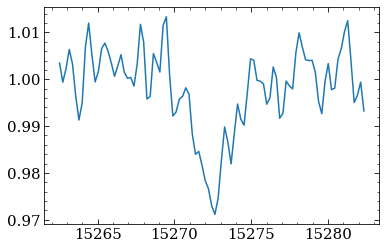

In [10]:
fig, ax  = plt.subplots()
ax.plot(wavs[window], signals_fg[2, :, 0])

In [11]:
def gaussfn(x, v, amp, sig0 = sigma0, offset = 0):
    wl0 = dopplershift(v, lambda0 = lambda0)
    return (1+offset) - amp * np.exp(-(x - wl0)**2 / (2 * sig0**2))

def loglikely(signals, errors, v, amp, sig0 = sigma0, offset = 0):
    # wl0 = dopplershift(v, lambda0 = lambda0)
    models = gaussfn(wavs[window], v, amp, sig0 = sig0, offset = offset)
    chi2 = -0.5 * np.nansum((signals - models)**2 / errors**2)
    if np.isnan(chi2):
        return -np.inf
    else:
        return chi2

prior_kws = {'vmax': 20, 'amp_max': 0.1, 'sig_min': 0.5, 'sig_max': 3, 'offset_max': 0.02}
def logprior(v, amp, sig0, offset, prior_kws = prior_kws):
    pval = 0
    if np.any(np.abs(v) > prior_kws['vmax']):
        pval += - np.inf
    if np.any((amp < 0) | (amp > prior_kws['amp_max'])):
        pval += -np.inf
    if np.any((sig0 < prior_kws['sig_min']) | (sig0 > prior_kws['sig_max'])):
        pval += -np.inf
    if np.any(np.abs(offset) > prior_kws['offset_max']):
        pval += -np.inf
    return pval

def logprob(p, data = signals_fg):
    v = p[0]
    amp = p[1]
    sig0 = p[2]
    offset = p[3]

    signals = data[:, 0]
    errors = data[:, 1]

    return loglikely(signals, errors, v, amp, sig0 = sig0, offset = offset) + logprior(v, amp, sig0, offset)

In [12]:
nwalkers = 50
ndim = 4
init = np.zeros((nwalkers, ndim))
init[:, 0] = 5 * (np.random.random(nwalkers)-0.5)
init[:, 1] = 0.05 + 0.01 * np.random.random(nwalkers)
init[:, 2] = 1.2 + 0.2 * np.random.random(nwalkers)
init[:, 3] = 0.01 * np.random.random(nwalkers)

sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, kwargs = {'data': signals_fg[2, :, :]})

In [13]:
import numpy as np

a1 = np.array([]).reshape(0,4)
a2 = np.zeros((2, 3, 4)).reshape((-1, 4))
# a3 = np.zeros((3))
# np.concatenate((a1, a3))

np.vstack((a1, a2))

# a4 = np.array([1,2,3])
# a5 = np.concatenate((a4, a4, a4))

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [14]:
samples_array = np.array([]).reshape(0,4)
params = np.array([])
param_errs = np.array([])

nsteps = 250
for i in range(np.sum(front)):
    data = signals_fg[i, :, :]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, kwargs = {'data': data})
    sampler.run_mcmc(init, nsteps, progress = True)
    
    samples = sampler.chain[:, -50:, :].reshape((-1, 4))
    samples_array = np.vstack((samples_array, samples))

    medians = np.nanmedian(samples, axis = 0)
    stdevs = np.nanstd(samples, axis = 0, ddof = 1)
    params = np.concatenate((params, medians))
    param_errs = np.concatenate((param_errs, stdevs))

params = params.reshape((-1, 4))
param_errs = param_errs.reshape(-1, 4)

100%|██████████| 250/250 [00:04<00:00, 50.21it/s]


In [15]:
def plot_burnin(samples):
    samples = sampler.chain
    chainshape = samples.shape[-1]
    # samples = samples.reshape((-1, chainshape))
    fig, axs = plt.subplots(nrows = chainshape, sharex = True, gridspec_kw = {'hspace':0})
    lims = [(-12, 12), (0,0.1), (0.5, 3), (-0.05, 0.05)]
    for i in range(chainshape):
        ax = axs[i]
        ax.plot(samples[:, :,  i].T)
        ax.set_ylim(*lims[i])

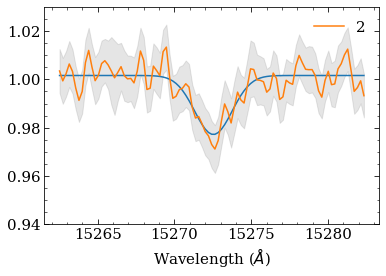

In [16]:
def plotmodel(index):
    fig, ax = plt.subplots()
    ax.plot(wavs[window], gaussfn(wavs[window], params[index, 0], params[index, 1], sig0 = params[index, 2], offset = params[index, 3]))
    ax.plot(wavs[window], signals_fg[index, :, 0], label = str(index))
    ax.fill_between(wavs[window], signals_fg[index, :, 0] + signals_fg[index, :, 1], signals_fg[index, :, 0] - signals_fg[index, :, 1], color = 'grey', alpha = 0.2)
    ax.legend()
    ax.set_xlabel('Wavelength ($\AA$)')
    ax.set_ylim(0.94, 1.03)
    return fig, ax
plotmodel(2)
plt.show()

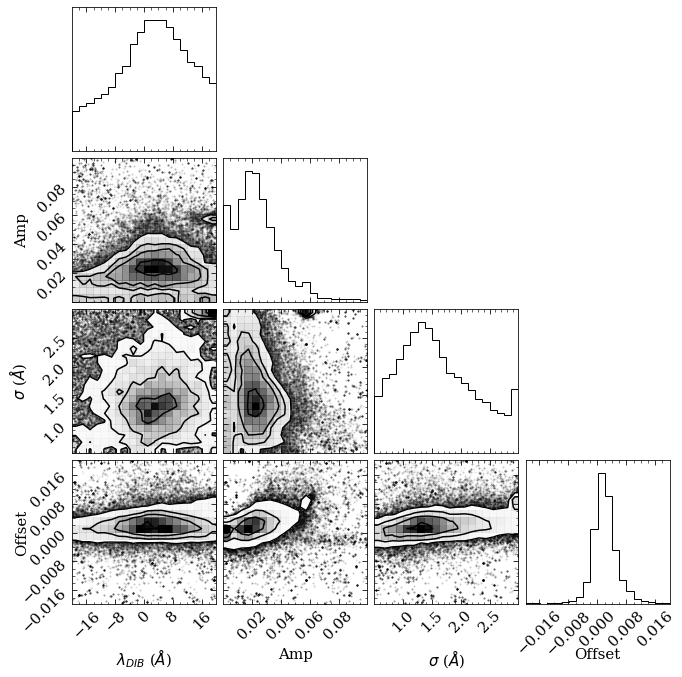

In [17]:
# samples = sampler.chain[:, nsteps -50:, :].reshape((-1, 4))
fig = corner.corner(samples_array, figsize = (12, 12), labels = [r'$\lambda_{DIB}$ ($\AA$)', 'Amp',r'$\sigma$ ($\AA$)', 'Offset'])
plt.show()

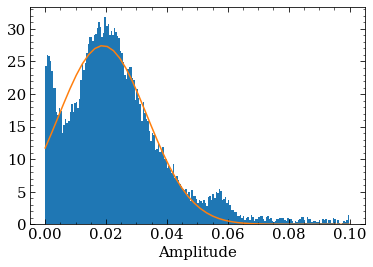

In [18]:
fig, ax = plt.subplots()
histy, histx, _ = ax.hist(samples_array[:,1], bins = 200, density = True)
ax.set_xlabel('Amplitude')

xfit = np.linspace(0.0, 0.1)
f = lambda x, mu, sigma : 1/(np.sqrt(2 * np.pi ) * sigma ) * np.exp(-(x - mu)**2 / (2 * sigma**2))


ampfit = curve_fit(f, histx[1:], histy)

ax.plot(xfit, f(xfit, *ampfit[0]))
plt.show()

In [19]:
print(ampfit[0])

[0.01896155 0.01454058]


In [20]:
eqw = np.sqrt(2 * np.pi) * params[:, 1] * params[:, 2]

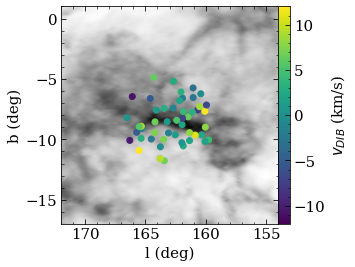

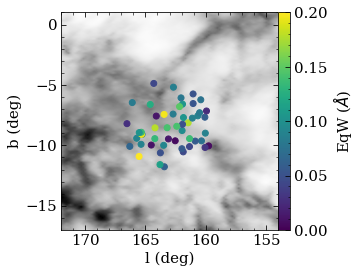

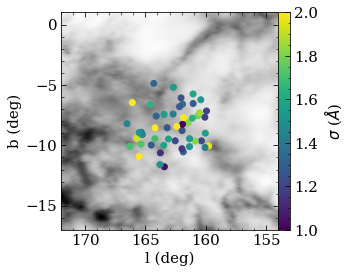

In [21]:
fig, ax = plt.subplots()
im = ax.imshow(np.nansum(dust_data.dustmap, axis = 2), origin = 'lower', cmap = 'binary', extent = (dust_data.l0-9, dust_data.l0+9, dust_data.b0-9, dust_data.b0+9))
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')

points = ax.scatter(CA_meta[front]['GLON'], CA_meta[front]['GLAT'], c = params[:, 0], vmin = -12, vmax = 12)

cax0 = ax.inset_axes([dust_data.l0-10,dust_data.b0-9 , 1, 18], transform =ax.transData)

fig.colorbar(points, ax = ax, cax = cax0, label = r'$v_{DIB}$ (km/s)')
xmin, xmax = ax.get_xlim()
# ax.legend(loc = 'upper left')
ax.set_xlim(xmax, xmin)

plt.show()

fig, ax = plt.subplots()
im = ax.imshow(np.nansum(dust_data.dustmap[:, :, :400], axis = 2), origin = 'lower', cmap = 'binary', extent = (dust_data.l0-9, dust_data.l0+9, dust_data.b0-9, dust_data.b0+9))
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')

points = ax.scatter(CA_meta[front]['GLON'], CA_meta[front]['GLAT'], c = eqw, vmin = 0, vmax = 0.2)

cax0 = ax.inset_axes([dust_data.l0-10,dust_data.b0-9 , 1, 18], transform =ax.transData)

fig.colorbar(points, ax = ax, cax = cax0, label = r'EqW ($\AA$)')
xmin, xmax = ax.get_xlim()
# ax.legend(loc = 'upper left')
ax.set_xlim(xmax, xmin)

plt.show()

fig, ax = plt.subplots()
im = ax.imshow(np.nansum(dust_data.dustmap[:, :, :400], axis = 2), origin = 'lower', cmap = 'binary', extent = (dust_data.l0-9, dust_data.l0+9, dust_data.b0-9, dust_data.b0+9))
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')


points = ax.scatter(CA_meta[front]['GLON'], CA_meta[front]['GLAT'], c = params[:, 2], vmin = 1, vmax = 2)

cax0 = ax.inset_axes([dust_data.l0-10,dust_data.b0-9 , 1, 18], transform =ax.transData)

fig.colorbar(points, ax = ax, cax = cax0, label = r'$\sigma$ ($\AA$)')
xmin, xmax = ax.get_xlim()
# ax.legend(loc = 'upper left')
ax.set_xlim(xmax, xmin)

plt.show()

In [22]:
print(np.sum(front))

52


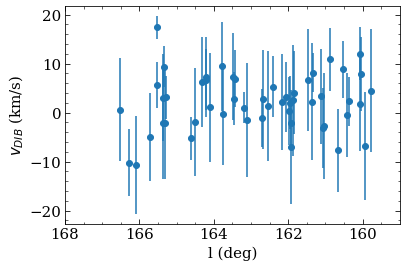

In [23]:
fig, ax = plt.subplots()
ax.errorbar(CA_meta[front]['GLON'], params[:, 0], yerr = param_errs[:, 0], fmt = 'o')
ax.set_xlabel('l (deg)')
ax.set_xlim(168, 159)
ax.set_ylabel(r'$v_{DIB}$ (km/s)')
plt.show()

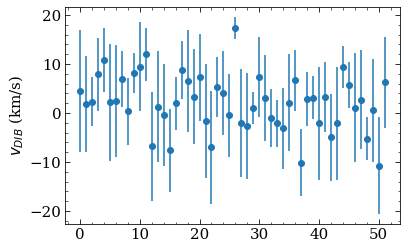

In [24]:
fig, ax = plt.subplots()
ax.errorbar(np.arange(np.sum(front)), params[:, 0], yerr = param_errs[:, 0], fmt = 'o')
# ax.set_xlabel('l (deg)')
# ax.set_xlim(168, 159)
ax.set_ylabel(r'$v_{DIB}$ (km/s)')
plt.show()

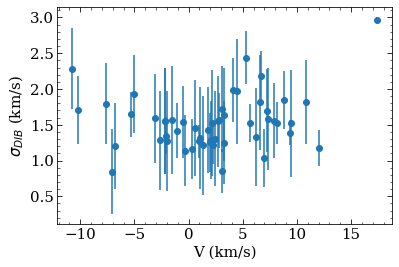

In [25]:
fig, ax = plt.subplots()
ax.errorbar(params[:, 0], params[:, 2], yerr = param_errs[:, 2], fmt = 'o')
# ax.set_xlabel('l (deg)')
# ax.set_xlim(172, 154)
ax.set_ylabel(r'$\sigma_{DIB}$ (km/s)')
ax.set_xlabel('V (km/s)')
plt.show()

26


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='Wavelength ($\\AA$)'>)

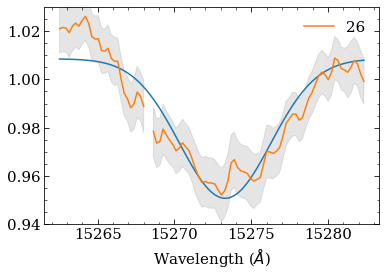

In [26]:
i3 = np.argmax(params[:, 0])
print(i3)
plotmodel(i3)

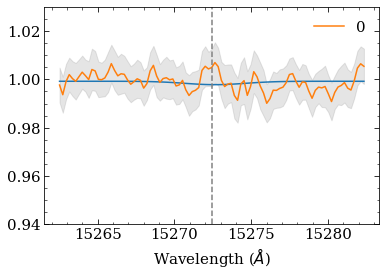

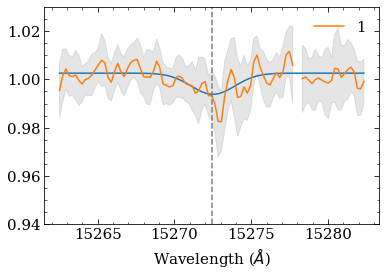

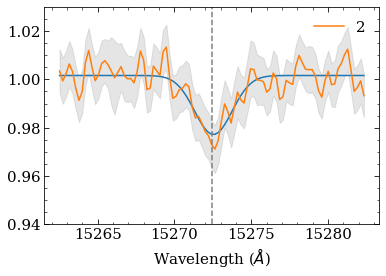

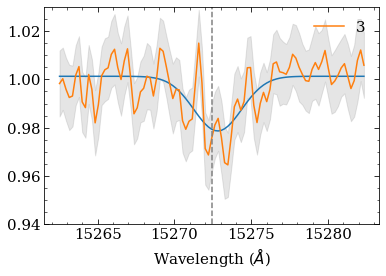

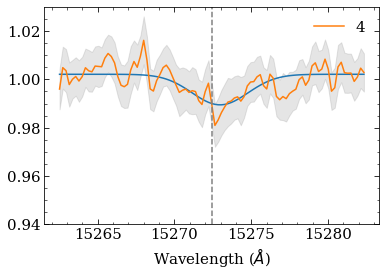

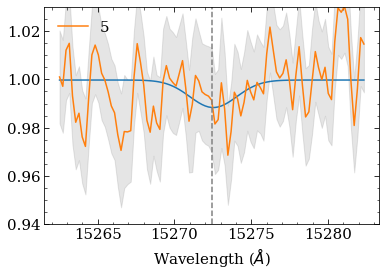

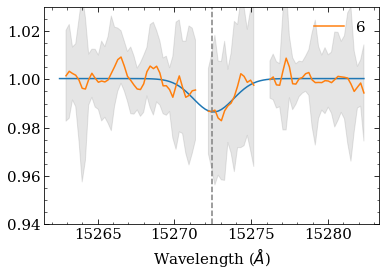

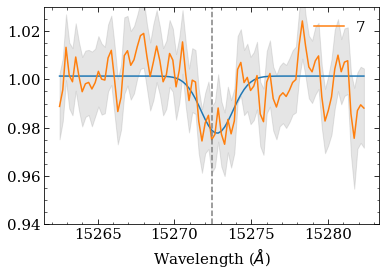

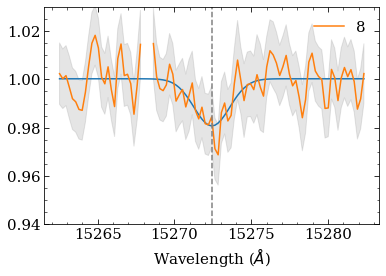

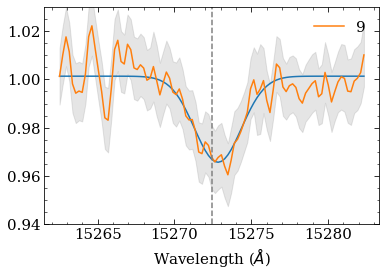

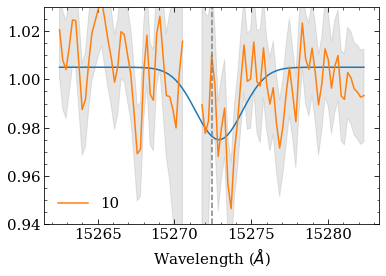

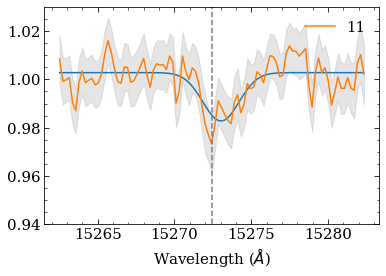

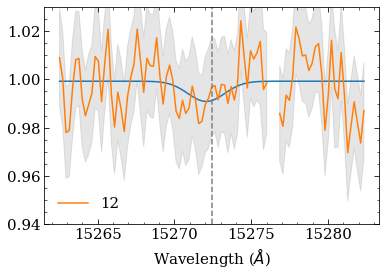

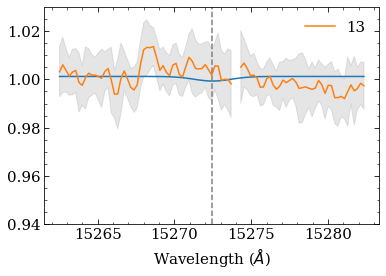

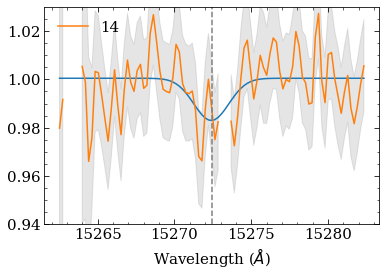

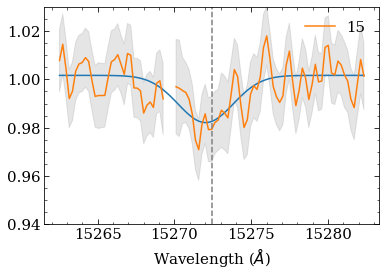

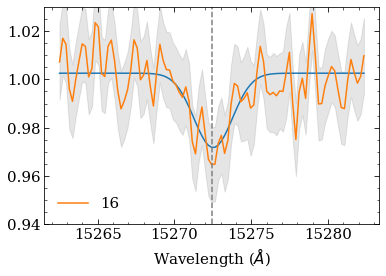

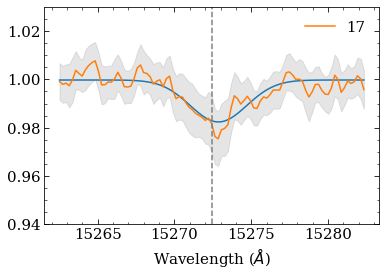

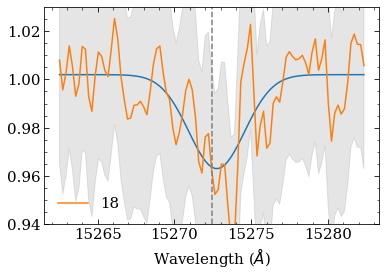

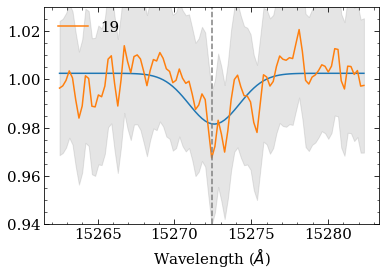

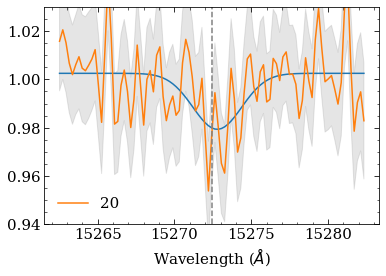

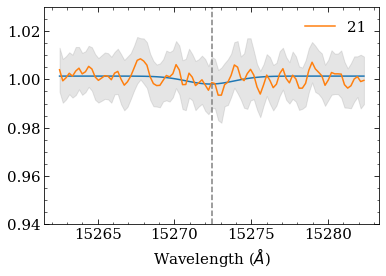

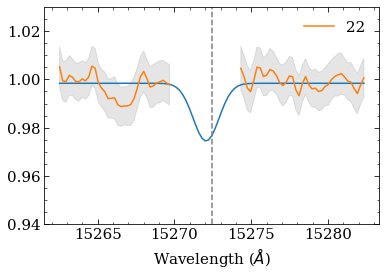

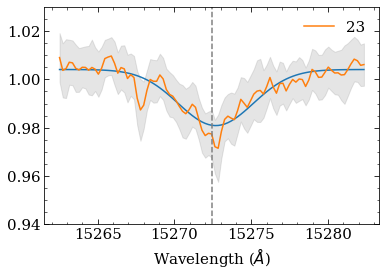

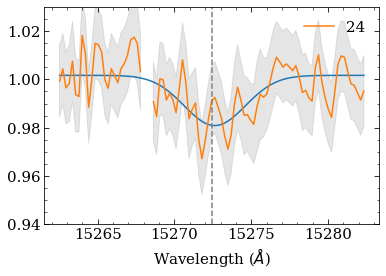

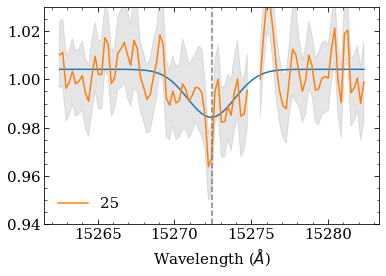

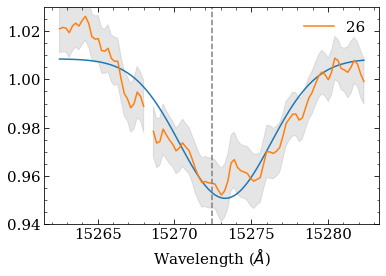

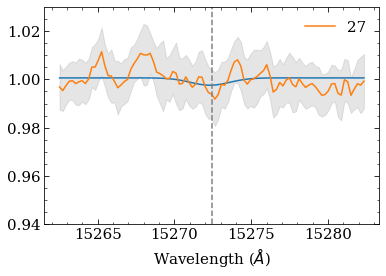

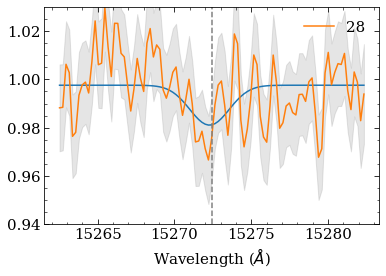

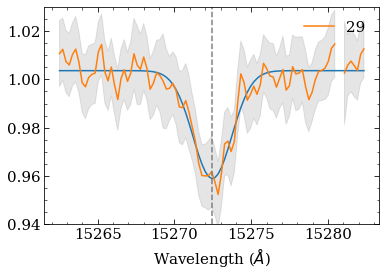

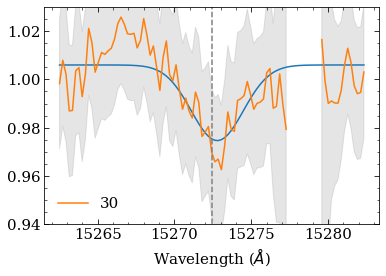

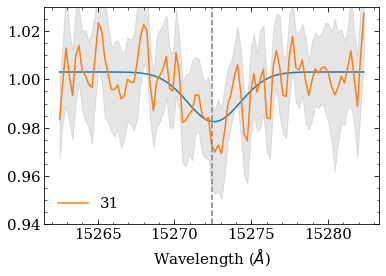

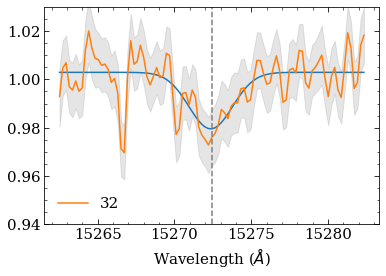

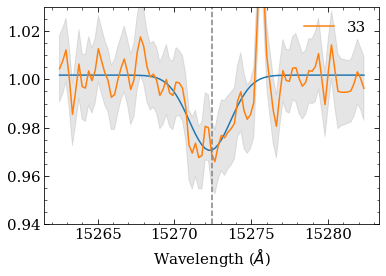

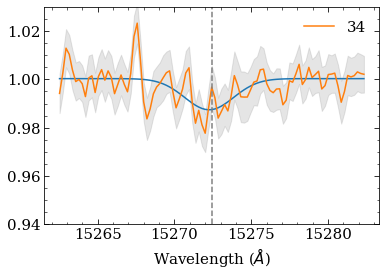

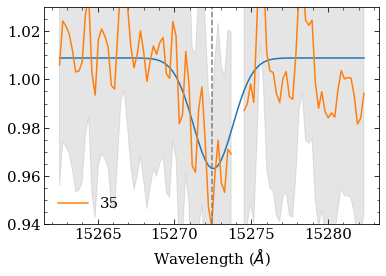

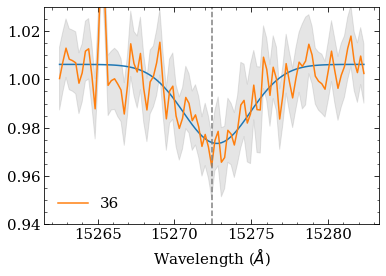

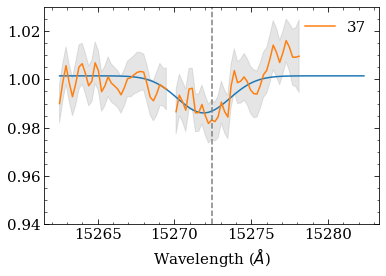

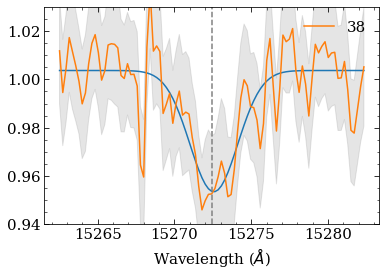

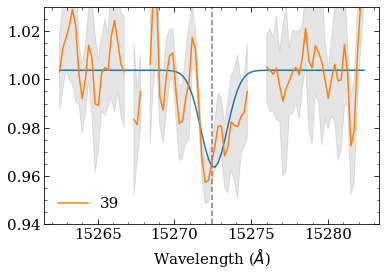

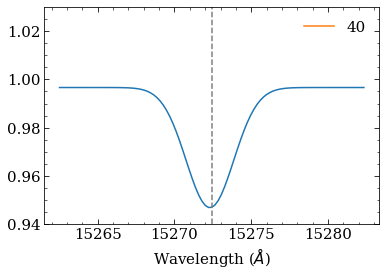

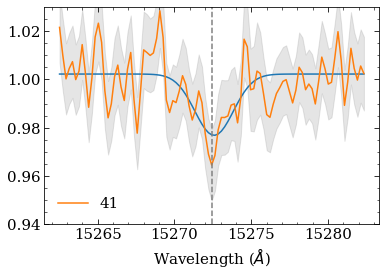

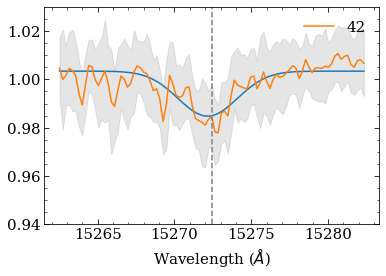

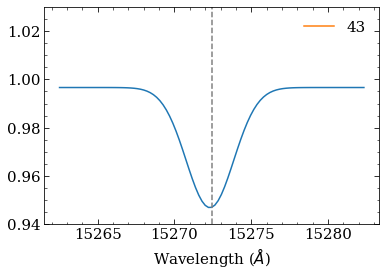

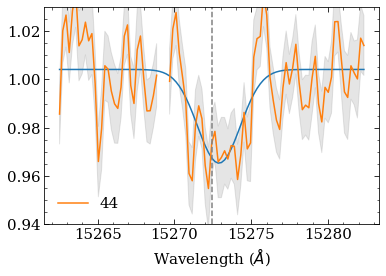

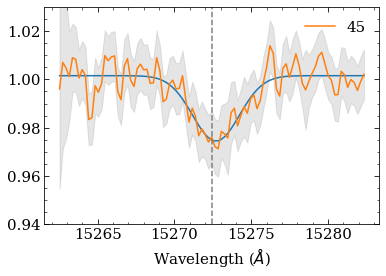

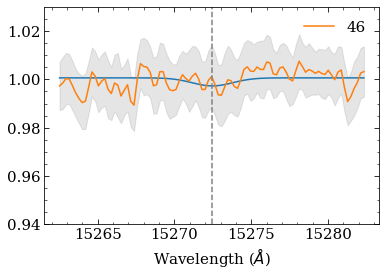

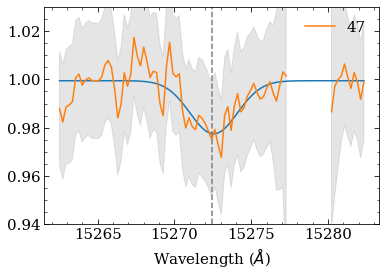

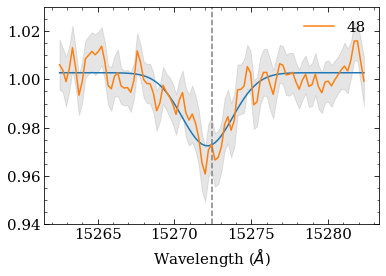

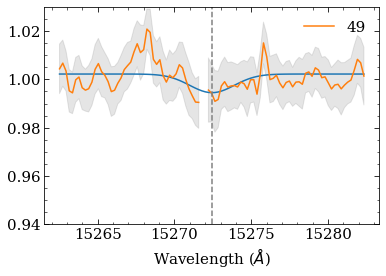

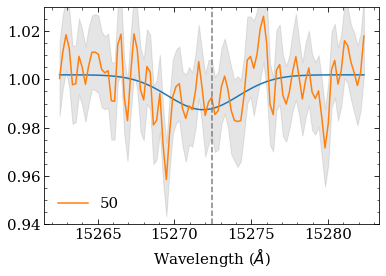

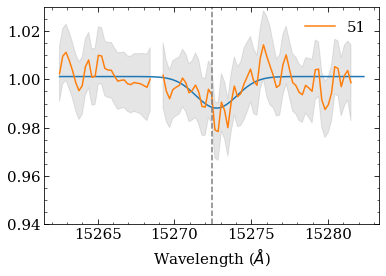

In [27]:
for i in range(np.sum(front)):
    fig, ax = plotmodel(i)
    ax.plot([lambda0, lambda0],[0.94, 1.03], linestyle = 'dashed', c= 'grey')
    plt.show()

poorfits = [5, 10, 12, 13,22, 26, 28, 40, 43]

In [28]:
CA_meta[front][i3]

APOGEE_ID,TELESCOPE,FIELD,RA,DEC,GLON,GLAT,J,H,K,AK_TARG,AK_WISE,VHELIO_AVG,GAIAEDR3_PARALLAX,TEFF,LOGG,M_H,ALPHA_M,ASPCAP_CHI2_1,MEDRES_NBIN,FILE,DIST,SFD_EBV,SNR,ASPCAPFLAG,STARFLAG,ASPCAP_CHI2_2,CONT_SHIFT,VERG_AV,VERG_AV_ERR,ALLSTAR_IDX,dist16,dist50,dist84,AV16,AV50,AV84
str30,str6,str20,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,str27,float32,float32,float32,int64,int64,float32,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32
2M04235959+3350433,apo25m,CA_165-10_btx,65.998325,33.845364,165.52348618517684,-10.920742754225584,7.538,7.445,7.395,0.014687985,0.014687985,25.447735,7.3032713,6595.8906,3.7022352,0.033676,0.091615304,5.260173,135,res_2M04235959+3350433.fits,136.92494,0.39149392,153.48729,1073758208,50462720,5.260173,0.004363712727813107,1.2009583988629757,0.0022,98292,--,--,--,--,--,--


In [29]:
weird_hdul = fits.open(get_ca_res(CA_meta['FILE'][front][i3]))

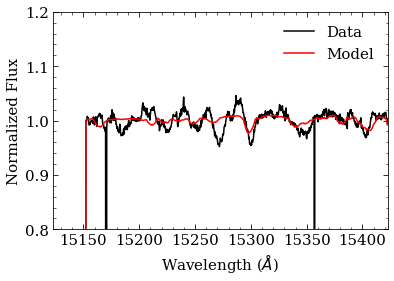

In [30]:
fig, ax = plt.subplots()
ax.plot(wavs, weird_hdul[3].data[0, :], label = 'Data', color='k')
ax.plot(wavs, weird_hdul[3].data[2, :], label = 'Model', color='r')

ax.set_xlim(lambda0 - 150, lambda0 + 150, )
ax.set_ylim(0.8, 1.2)
ax.legend()
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('Normalized Flux')
plt.show()

(5.0, 2.0)

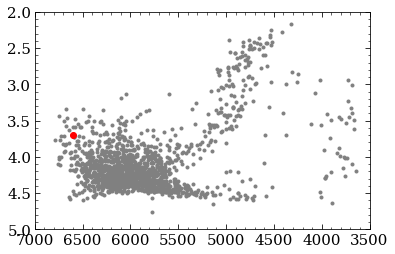

In [31]:
fig, ax = plt.subplots()
ax.scatter(CA_meta['TEFF'], CA_meta['LOGG'], c= 'grey', marker = '.')
ax.scatter(CA_meta['TEFF'][front][i3], CA_meta['LOGG'][front][i3], c= 'r', marker = 'o')
ax.set_xlim(7e3, 3.5e3)
ax.set_ylim(5, 2)

In [32]:
X = np.array([[1, 2, 4], [1, 3, 5 ]])
b = np.array([1/2, 1/3, 1/4])
print(X * b)




[[0.5        0.66666667 1.        ]
 [0.5        1.         1.25      ]]


In [33]:
### PLANE FITTING ###

In [34]:
# params[i3, :] = 0
# param_errs[i3, :] = np.inf

params[np.array(poorfits), :] = 0
param_errs[np.array(poorfits), :] = np.inf

mask = np.isin(np.arange(len(params)), poorfits)
mask = np.array([mask, mask, mask, mask]).T
params = np.ma.array(params, mask = mask)
param_errs = np.ma.array(param_errs, mask = mask)

In [35]:
np.outer(np.arange(0,2,1), np.arange(0,2,1))

array([[0, 0],
       [0, 1]])

In [36]:
# def poly2d(theta, x1, x2):  
#     X = np.ones((2, len(theta), len(x1)))
#     X[0, 1, :] = x1
#     X[0, 2, :] = x1**2
#     X[1, 1, :] = x2
#     X[1, 2, :] = x2**2 
#     X = np.array([[np.ones(len(x1)), x1, x1**2], [np.ones(len(x1)), x2, x2**2]])
#     matrix = X * theta[np.newaxis, :, np.newaxis]
#     return np.nansum(np.nansum(matrix, axis = 1), axis = 0)

def poly2d(theta, x1, x2):  
    x1 = x1 - 160
    x2 = x2 + 8
    X = np.array([[np.ones(len(x1)), x1, x2]]).T# , x1 * x2, x1**2, x2**2]]).T
    matrix = X * theta[:, np.newaxis]
    return np.nansum(matrix, axis = 1)

# def Npoly2d(theta, x1, x2, N):
    




# def transform_theta(theta, forward = True):
#     if forward: 
#         theta[1:] = theta[1:] / 1e1
#         # theta[3:] = theta[3:] / 1e2
#     else:
#         theta[1:] = theta[1:] * 1e1
#         # theta[3:] = theta[3:] * 1e2
#     return theta

coords = (CA_meta['GLON'][front], CA_meta['GLAT'][front])
def llikely(theta, coords = coords, data = params[:, 0], err = param_errs[:, 0], **kwargs):
    x1, x2 = coords 
    th = np.copy(theta)
    th[0] = th[0] * 100
    chi2 = - 0.5 * np.nansum((data - poly2d(th, x1, x2))**2 /err**2) 
    return chi2
def lprior(theta):
    # order0 = theta[0]
    # order1 = theta[1:3]
    # order2 = theta[3:]
    # if np.any(np.abs(order0 - 150) > 50):
    #     return -np.inf
    # if np.any(np.abs(order1) > 20): 
    #     return -np.inf
    # if np.any(np.abs(order2) > 10):
    #     return -np.inf 
    # return 0
    if np.any(np.abs(theta) > 100):
        return - np.inf 
    return 0

def lprob(theta, **kwargs):
    # theta = transform_theta(theta, forward = True)
    return llikely(theta, **kwargs) # lprior(theta)

In [37]:
lx = np.linspace(156, 167, 75)
by = np.linspace(-12, -4)
x, y = np.meshgrid(lx, by)

In [38]:
from scipy.optimize import curve_fit

def fn(X, b, m1, m2):
    x1, x2 = (X[0, :], X[1, :])
    theta = np.array([b, m1, m2])
    result = poly2d(theta, x1, x2)
    return result.flatten()

fit= curve_fit(fn, np.array(coords),  params[:,0], sigma = param_errs[:, 0],)

In [91]:
def polynomial2d(theta, x1, x2, previously_fit = False):  
    if np.array(x1).ndim != 1:
        # print(x1.shape)
        x1 = np.array([x1])
        x2 = np.array([x2])

    if previously_fit:
        theta = np.array([ 4.49522961, -0.73790365, -1.34234273, -0.03195848, -0.02369509, -0.14884087])
    x1 = x1 - 160
    x2 = x2 + 8
    # X = np.array([[np.ones(len(x1)), x1, x2 , x1**2, x2**2]]).T
    X = np.array([[np.ones(np.array(x1).shape), x1, x2, x1 * x2, x1**2, x2**2]]).T

    matrix = X * theta[:, np.newaxis]
    # print(matrix.shape)
    return np.nansum(matrix, axis = 1)

def fn_2(X, a0, a1_1, a1_2, a2_12, a2_1, a2_2):
    x1, x2 = (X[0, :], X[1, :])
    theta = np.array([a0, a1_1, a1_2, a2_12, a2_1, a2_2])
    return polynomial2d(theta, x1, x2).flatten()

fit_2= curve_fit(fn_2, np.array(coords),  params[:,0], sigma = param_errs[:, 0])


In [83]:
np.array(0).ndim

0

In [92]:
polynomial2d(fit_2[0], 165, -10)

array([3.01891462])

In [40]:
fit_2[1].astype(float)

array([[ 3.45744493e+00, -2.01356912e+00,  3.83363746e-01,
        -1.08803285e-01,  2.57083857e-01, -8.16662909e-02],
       [-2.01356912e+00,  1.90999117e+00, -1.41656905e-01,
         1.68428934e-02, -2.92576520e-01, -5.13032801e-02],
       [ 3.83363746e-01, -1.41656905e-01,  1.01039072e+00,
        -2.62311204e-01, -5.26127413e-04,  3.71431128e-02],
       [-1.08803285e-01,  1.68428934e-02, -2.62311204e-01,
         9.35390292e-02,  6.91138505e-03,  2.74284737e-03],
       [ 2.57083857e-01, -2.92576520e-01, -5.26127413e-04,
         6.91138505e-03,  4.92833679e-02,  9.03187799e-03],
       [-8.16662909e-02, -5.13032801e-02,  3.71431128e-02,
         2.74284737e-03,  9.03187799e-03,  6.75478423e-02]])

In [41]:
xx1 = [1, 2, 3]
yy1 = [1,2,3]

np.polynomial.polynomial.polyval2d(xx1, yy1, 1)

array([ 3.,  7., 13.])

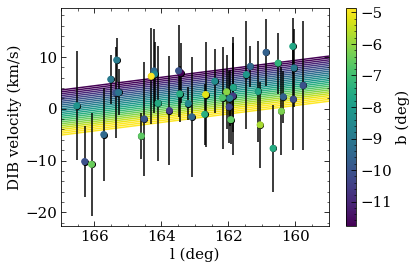

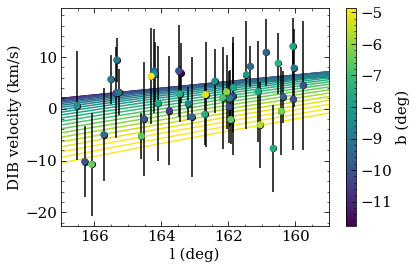

In [42]:
from matplotlib import colors, cm

norm= colors.Normalize(np.nanmin(CA_meta[front]['GLAT']), np.nanmax(CA_meta[front]['GLAT']))
mappable = cm.ScalarMappable(norm = norm)
colors = cm.viridis(norm(by))


fig, ax = plt.subplots()
ax.errorbar(CA_meta[front]["GLON"], params[:, 0], yerr = param_errs[:, 0], fmt = 'o', color = 'k')
for i in range(0, len(by), 2):
    ax.plot(lx, fn(np.array([x.ravel(), y.ravel()]), *fit[0]).reshape(len(by), len(lx))[i, :], color = colors[i], zorder = 0)
ax.scatter(CA_meta[front]["GLON"], params[:, 0], c = CA_meta[front]['GLAT'], zorder = 3, norm = norm)

ax.set_xlabel('l (deg)')
ax.set_ylabel("DIB velocity (km/s)")
fig.colorbar(mappable, label = 'b (deg)')
ax.set_xlim(167, 159)
fig.set_facecolor('white')
plt.show()

fig, ax = plt.subplots()
ax.errorbar(CA_meta[front]["GLON"], params[:, 0], yerr = param_errs[:, 0], fmt = 'o', color = 'k')
ax.scatter(CA_meta[front]["GLON"], params[:, 0], c = CA_meta[front]['GLAT'], zorder = 3, norm = norm)

for i in range(0, len(by), 2):
    ax.plot(lx, fn_2(np.array([x.ravel(), y.ravel()]), *fit_2[0]).reshape(len(by), len(lx))[i, :], color = colors[i], zorder = 0)

ax.set_xlabel('l (deg)')
ax.set_ylabel("DIB velocity (km/s)")
fig.colorbar(mappable, label = 'b (deg)')

ax.set_xlim(167, 159)

plt.show()

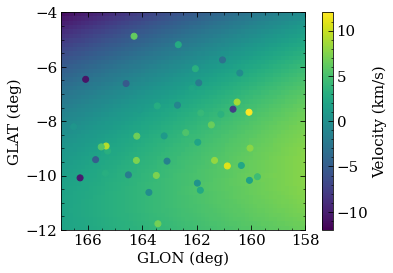

In [43]:
fig, ax = plt.subplots()
im = ax.imshow(fn_2(np.array([x.ravel(), y.ravel()]), *fit_2[0]).reshape(len(by), len(lx)), vmin = -12, vmax = 12, extent =(156, 167, -12, -4), origin = 'lower' )
points = ax.scatter(CA_meta[front]['GLON'], CA_meta[front]['GLAT'], c = params[:, 0], vmin = -12, vmax = 12)
ax.set_xlabel("GLON (deg)")
ax.set_ylabel("GLAT (deg)")
ax.set_xlim(167, 158)
fig.set_facecolor('white')
fig.colorbar(im, label = 'Velocity (km/s)')
plt.show()

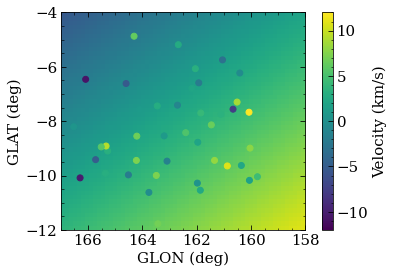

In [44]:
fig, ax = plt.subplots()
im = ax.imshow(fn(np.array([x.ravel(), y.ravel()]), *fit[0]).reshape(len(by), len(lx)), vmin = -12, vmax = 12, extent =(156, 167, -12, -4), origin = 'lower' )
points = ax.scatter(CA_meta[front]['GLON'], CA_meta[front]['GLAT'], c = params[:, 0], vmin = -12, vmax = 12)
ax.set_xlabel("GLON (deg)")
ax.set_ylabel("GLAT (deg)")
ax.set_xlim(167, 158)
fig.set_facecolor('white')
fig.colorbar(im, label = 'Velocity (km/s)')

plt.show()

In [45]:
# fig, ax = plt.subplots()
# ax.scatter(fit[0], params[:, 0])
# plt.show()

In [46]:
item1 = poly2d(fit[0], *coords).flatten()
item1min, item1max = ((poly2d(fit[0] - np.sqrt(np.diag(fit[1])), *coords)).flatten(), (poly2d(fit[0] + np.sqrt(np.diag(fit[1])), *coords)).flatten())

item2 = polynomial2d(fit_2[0], *coords).flatten()
item2min, item2max = ((polynomial2d(fit_2[0] - np.sqrt(np.diag(fit_2[1])), *coords)).flatten(), 
                      (polynomial2d(fit_2[0] + np.sqrt(np.diag(fit_2[1])), *coords)).flatten())


print(np.nansum((item1 - params[:, 0])**2 / param_errs[:, 0]**2) )
print(np.nansum((item2 - params[:, 0])**2 / param_errs[:, 0]**2) )

22.369564971470638
21.93838591475391


In [47]:
param_errs[:, 0]

masked_array(data=[12.51337244229351, 9.773564787254603, 4.97380735300741,
                   7.467578036654752, 6.489599927252407, --,
                   11.373701855557455, 5.752254197150978,
                   6.888308118434993, 4.0299585471691035, --,
                   5.400076686474304, --, --, 10.428134111809957,
                   8.452697479149457, 5.426123443243867,
                   5.8865992467330335, 10.399019444695721,
                   9.74856331153103, 8.873330736546906,
                   11.616673213780084, --, 6.187458481247427,
                   8.50644884390518, 8.527508546347025, --,
                   11.026342589858297, --, 3.220456433253818,
                   8.14850953439778, 8.788514281206298,
                   5.8671254911270445, 4.77513774506654,
                   8.227933805175043, 9.819941772143375,
                   6.197083402356987, 6.834004861637585,
                   5.427589692910554, 4.432468156172652, --,
                   7.1591967158868

2.4676527942614768


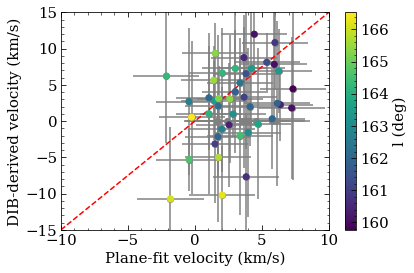

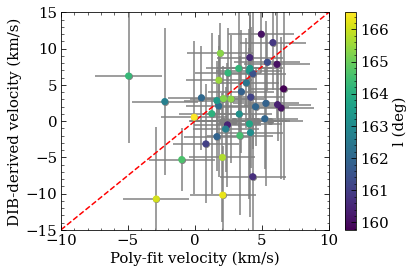

In [48]:
v_stdev = np.nanstd(param_errs[:, 0], ddof = 1)
print(v_stdev)

fig, ax = plt.subplots()

ax.errorbar(np.array(item1), np.array(params[:, 0]), yerr = param_errs[:,0], xerr = v_stdev, fmt  = 'o', color = 'grey')
points = ax.scatter(item1, params[:, 0], c = CA_meta[front]['GLON'], zorder = 3)
ax.plot((-10, 10), (-15, 15), linestyle = 'dashed', c= 'r')
ax.set_xlabel('Plane-fit velocity (km/s)')
ax.set_ylabel('DIB-derived velocity (km/s)')
# ax.set_aspect('equal')
ax.set_xlim(-10, 10)
ax.set_ylim(-15, 15)
fig.colorbar(points, label = 'l (deg)')
plt.show()

fig, ax = plt.subplots()
ax.errorbar(np.array(item2), np.array(params[:, 0]),fmt = 'o', color = 'grey', yerr = param_errs[:,0], xerr = v_stdev)# 
ax.plot((-10, 10), (-15, 15), linestyle = 'dashed', c= 'r')
ax.set_xlabel('Poly-fit velocity (km/s)')
ax.set_ylabel('DIB-derived velocity (km/s)')
# ax.set_aspect('equal')
# ax.scatter(item1, params[:, 0], c = CA_meta[front]['GLON'], zorder = 3)
points = ax.scatter(item2, params[:, 0], c = CA_meta[front]['GLON'], zorder = 3)

ax.set_xlim(-10, 10)
ax.set_ylim(-15, 15)
fig.colorbar(points, label = 'l (deg)')

plt.show()

In [49]:
print('THINGS THAT GO INTO THE PRIORS')
print('VELOCITY SURFACE FIT PARAMETERS')
print(fit_2[0])
print('VELOCITY STDEV')
print(v_stdev)
print('AMPLITUDE GAUSSIAN FIT PARAMETERS')
print(ampfit[0])


THINGS THAT GO INTO THE PRIORS
VELOCITY SURFACE FIT PARAMETERS
[ 5.392416   -0.81036945 -1.01693307 -0.08595474 -0.01077972 -0.23639365]
VELOCITY STDEV
2.4676527942614768
AMPLITUDE GAUSSIAN FIT PARAMETERS
[0.01896155 0.01454058]


In [50]:
params

masked_array(
  data=[[4.466999928322824, 0.001406809870832686, 1.9670280746350104,
         -0.0007989109624094376],
        [1.8261621807320116, 0.008748374560232298, 1.4255787032056157,
         0.0025524020958796493],
        [2.291100288402305, 0.024420600084559, 1.215065742899157,
         0.0015905254003272693],
        [7.845542066114314, 0.02263143020072735, 1.557863514589044,
         0.0012634071935261673],
        [10.855053296907716, 0.012650594187207636, 1.821293909118191,
         0.002090243447885499],
        [--, --, --, --],
        [2.464193293248659, 0.013823570650533957, 1.301575564350657,
         0.00031779980365552636],
        [6.926730089368291, 0.023664872249019996, 1.035819843336963,
         0.0013527929037725262],
        [0.33620233528873067, 0.01950540905681718, 1.1618366182806268,
         0.00023324440374063692],
        [8.133255064010541, 0.035627605960466865, 1.5282431455419085,
         0.001305150015940306],
        [--, --, --, --],
        [12.

In [51]:
coords[0].shape

(52,)

In [52]:
from scipy.stats import spearmanr 
spearmanr(coords[0], params[:, 0])

SpearmanrResult(correlation=-0.22605569691993307, pvalue=0.10708813349810668)

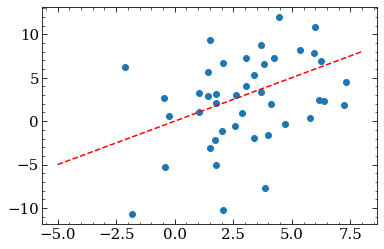

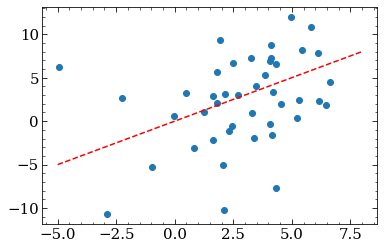

In [53]:
fig, ax = plt.subplots()
ax.scatter(item1, params[:, 0])
ax.plot((-5, 8), (-5, 8), linestyle = 'dashed', c= 'r')
plt.show()

fig, ax = plt.subplots()
ax.scatter(item2, params[:, 0])
ax.plot((-5, 8), (-5, 8), linestyle = 'dashed', c= 'r')
plt.show()

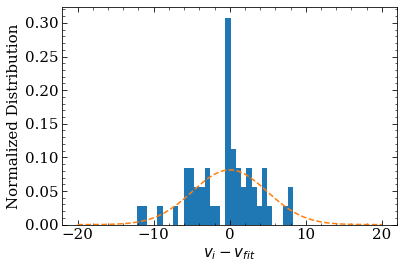

In [54]:
fig, ax = plt.subplots()
ax.hist(params[:, 0]-item1.flatten(), bins = 30, density = True)
x_plot = np.linspace(-20, 20)
stdev = np.nanstd(params[:, 0]-item1.flatten(), ddof = 1)
ax.plot(x_plot, 1/(np.sqrt(2 * np.pi) * stdev) * np.exp(-(x_plot**2)/(2 * stdev**2)), linestyle = 'dashed')
ax.set_xlabel('$v_i - v_{fit}$')
ax.set_ylabel("Normalized Distribution")
plt.show()

In [55]:
item1

array([ 7.326007  ,  7.23374027,  6.38292082,  5.9363822 ,  5.98124568,
        6.10042557,  6.16262498,  6.25691896,  5.78205047,  5.37095821,
        5.76041047,  4.44089121,  3.97781902,  4.6023426 ,  4.70538693,
        3.83649058,  4.12637507,  3.66772627,  3.82531971,  3.67938589,
        4.23596454,  3.9735149 ,  3.58084216,  3.37251181,  3.02379689,
        2.5611836 ,  3.59942134,  3.37375294,  2.39058418,  2.85624243,
        3.02332375,  2.61695636,  2.00298015,  1.72982371,  1.50608965,
        1.75556953,  2.04544639,  2.04488621,  1.42641976,  1.77721072,
        1.73376769,  1.05139017,  1.76666401,  1.64169247,  1.5254433 ,
        1.41588439,  1.04983453, -0.4428405 , -0.42466295, -0.23377682,
       -1.81180942, -2.11702082])

In [56]:
# np.nansum(np.exp(-(xx[:, np.newaxis] - (params[:, 0] - item))**2 / (2 * param_errs[:, 0]**2)), axis = 1)

In [57]:

fit_AMP = curve_fit(fn_2, np.array(coords),  params[:,1], sigma = param_errs[:, 1])



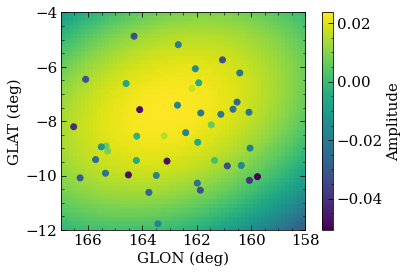

In [58]:
fig, ax = plt.subplots()
im = ax.imshow(fn_2(np.array([x.ravel(), y.ravel()]), *fit_AMP[0]).reshape(len(by), len(lx)),  extent =(156, 167, -12, -4), origin = 'lower' )
points = ax.scatter(CA_meta[front]['GLON'], CA_meta[front]['GLAT'], c = params[:, 1],)
ax.set_xlabel("GLON (deg)")
ax.set_ylabel("GLAT (deg)")
ax.set_xlim(167, 158)
fig.set_facecolor('white')
fig.colorbar(im, label = 'Amplitude')
plt.show()

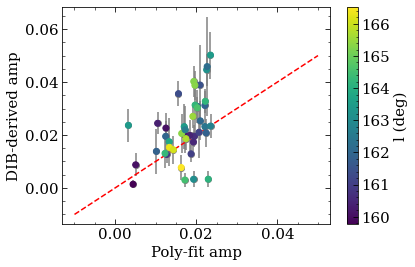

In [59]:
item_amp = polynomial2d(fit_AMP[0], *coords).flatten()
fig, ax = plt.subplots()
ax.errorbar(item_amp, params[:, 1],fmt = 'o', color = 'grey', yerr = param_errs[:,1],)# 
ax.plot((-0.01, 0.05), (-0.01, 0.05), linestyle = 'dashed', c= 'r')
ax.set_xlabel('Poly-fit amp')
ax.set_ylabel('DIB-derived amp')
# ax.set_aspect('equal')
# ax.scatter(item1, params[:, 0], c = CA_meta[front]['GLON'], zorder = 3)
points = ax.scatter(item_amp, params[:, 1], c = CA_meta[front]['GLON'], zorder = 3)

# ax.set_xlim(-10, 10)
# ax.set_ylim(-15, 15)
fig.colorbar(points, label = 'l (deg)')

plt.show()

In [60]:
item_amp

array([0.00442454, 0.00507392, 0.01047815, 0.01251606, 0.01268389,
       0.0115773 , 0.01018303, 0.00328505, 0.01245505, 0.01562287,
       0.00553228, 0.0171675 , 0.01724637, 0.01778851, 0.01333815,
       0.01955486, 0.02029049, 0.01930547, 0.02091138, 0.0206801 ,
       0.01703097, 0.01933738, 0.02169221, 0.02212065, 0.02244071,
       0.01839879, 0.01054314, 0.01718353, 0.02056105, 0.02255546,
       0.0197133 , 0.01640675, 0.02352028, 0.02212508, 0.01871604,
       0.02268755, 0.02223382, 0.01337802, 0.02350262, 0.01938201,
       0.01929321, 0.02100257, 0.01744735, 0.01931939, 0.019663  ,
       0.0191628 , 0.02296128, 0.01725646, 0.02027358, 0.01629816,
       0.01436112, 0.01230055])